In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#######
IN_DATA_FNAMES = ['/oak/stanford/orgs/kipac/users/delon/LensQuEst/map_sims_%d.pkl'%(i) for i in range(1,51)]
import warnings
warnings.filterwarnings("ignore")
#####

In [3]:
import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

In [4]:
from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle
import seaborn as sns
from scipy.stats import spearmanr
import matplotlib
from tqdm import trange, tqdm

In [5]:
print("Map properties")

# number of pixels for the flat map
nX = 800
nY = 800

# map dimensions in degrees
sizeX = 20.
sizeY = 20.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 32  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra

Map properties


In [6]:
oup_fname = '../data/input/universe_Planck15/camb/CAMB_outputs.pkl'
print(oup_fname)
f = open(oup_fname, 'rb') 
powers,cl,c_lensed,c_lens_response = pickle.load(f)
f.close()

totCL=powers['total']
unlensedCL=powers['unlensed_scalar']

L = np.arange(unlensedCL.shape[0])
unlensedTT = unlensedCL[:,0]/(L*(L+1))*2*np.pi
F = unlensedTT
funlensedTT_log = interp1d(L, np.log(F), kind='linear', bounds_error=False, fill_value=0.)
funlensedTT = lambda L:np.exp(funlensedTT_log(L))


L = np.arange(cl.shape[0])
PP = cl[:,0]
rawPP = PP*2*np.pi/((L*(L+1))**2)
rawKK = L**4/4 * rawPP

fKK_log = interp1d(L, np.log(rawKK), kind='linear', bounds_error=False, fill_value=0.)
ffKK = lambda L:np.exp(fKK_log(L))


L = np.arange(totCL.shape[0])

lensedTT = totCL[:,0]/(L*(L+1))*2*np.pi
F = lensedTT
flensedTT_log = interp1d(L, np.log(F), kind='linear', bounds_error=False, fill_value=0.)
flensedTT = lambda L:np.exp(flensedTT_log(L))


ftot = lambda l : flensedTT(l) + cmb.fForeground(l) + cmb.fdetectorNoise(l)


L = np.arange(c_lens_response.shape[0])

cTgradT = c_lens_response.T[0]/(L*(L+1))*2*np.pi

fTgradT_log = interp1d(L, np.log(cTgradT), kind='linear', bounds_error=False, fill_value=0.)
fTgradT = lambda L:np.exp(fTgradT_log(L))


../data/input/universe_Planck15/camb/CAMB_outputs.pkl


In [7]:
# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S4/SO specs
cmb = StageIVCMB(beam=1.4, noise=7., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: ftot(l) 

# reinterpolate: gain factor 10 in speed
# L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
# F = np.array(list(map(forCtotal, L)))
# cmb.fCtotal = interp1d(L, F, kind='cubic', bounds_error=False, fill_value=0.)
cmb.fCtotal = ftot # no longer reinterpolating since it seems like it leads to errors?

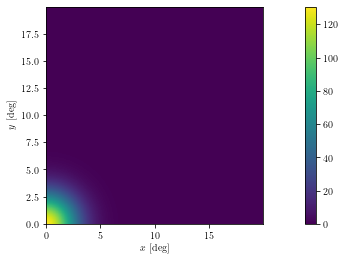

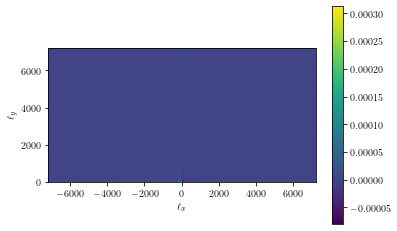

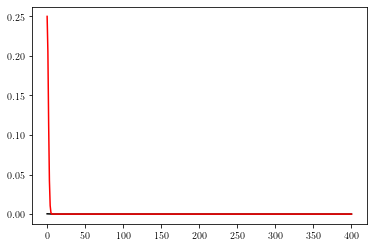

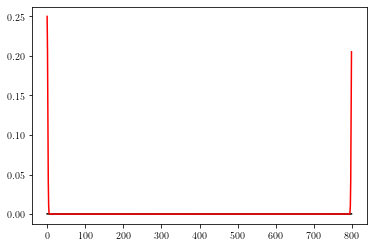

In [8]:
baseMap.testFourierGaussian()

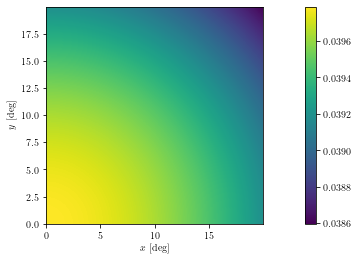

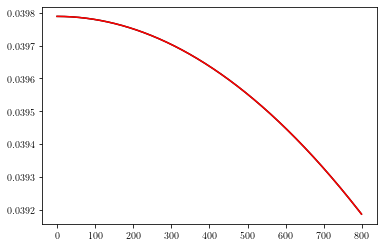

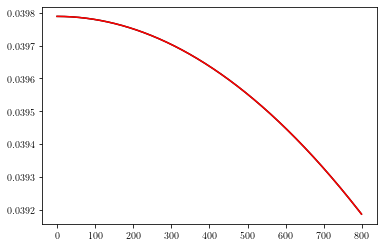

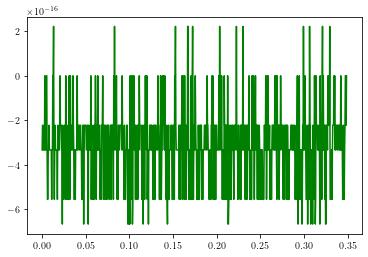

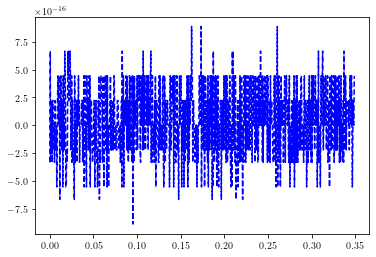

In [11]:
baseMap.testInverseFourier()